In [2]:
# Author: Nikolay Mayorov <nikolay.mayorov@zoho.com>

from __future__ import division
import numpy as np
import pandas as pd
from scipy.optimize import nnls


def _compute_cluster_sizes(n_samples, dt, tau_min, tau_max, n_clusters):
    if tau_min is None:
        min_size = 1
    else:
        min_size = int(tau_min / dt)

    if tau_max is None:
        max_size = n_samples // 10
    else:
        max_size = int(tau_max / dt)

    result = np.logspace(np.log2(min_size), np.log2(max_size),
                         num=n_clusters, base=2)

    return np.unique(np.round(result)).astype(int)


def allan_variance(x, dt=1, tau_min=None, tau_max=None,
                   n_clusters=100, input_type='mean'):
    """Compute Allan variance (AVAR).

    Consider an underlying measurement y(t). Our sensors output integrals of
    y(t) over successive time intervals of length dt. These measurements
    x(k * dt) form the input to this function.

    Allan variance is defined for different averaging times tau = m * dt as
    follows::

        AVAR(tau) = 1/2 * <(Y(k + m) - Y(k))>,

    where Y(j) is the time average value of y(t) over [k * dt, (k + m) * dt]
    (call it a cluster), and < ... > means averaging over different clusters.
    If we define X(j) being an integral of x(s) from 0 to dt * j,
    we can rewrite the AVAR as  follows::

        AVAR(tau) = 1/(2 * tau**2) * <X(k + 2 * m) - 2 * X(k + m) + X(k)>

    We implement < ... > by averaging over different clusters of a given sample
    with overlapping, and X(j) is readily available from x.

    Parameters
    ----------
    x : ndarray, shape (n, ...)
        Sensor readings, interpretation depends on `input_type` argument.
        Assumed to vary along the 0-th axis.
    dt : float, optional
        Sampling period. Default is 1.
    tau_min : float or None, optional
        Minimum averaging time to use. If None (default), it is assigned equal
        to `dt`.
    tau_max : float or None, optional
        Maximum averaging time to use. If None (default), it is chosen
        automatically such that to averaging is done over 10 *independent*
        clusters.
    n_clusters : int, optional
        Number of clusters to compute Allan variance for. The averaging times
        will be spread approximately uniform in a log scale. Default is 100.
    input_type : {'mean', 'increment', 'integral'}, optional
        How to interpret the input data:

            - 'mean': `x` is assumed to contain mean values of y over
              successive time intervals.
            - 'increment': `x` is assumed to contain integral increments over
              successive time intervals.
            - 'integral': `x` is assumed to contain cumulative integral of
              y from the time start.

        Note that 'mean' can be used when passing filtered and sampled value
        of y. But in this case generally the filtering process affects
        properties of the underlying signal y and "effective" Allan variance
        is computed, i.e. you can use obtained parameters when working with
        the sampled signal.

    Returns
    -------
    tau : ndarray
        Averaging times for which Allan variance was computed, 1-d array.
    avar : ndarray
        Values of AVAR. The 0-th dimension is the same as for `tau`. The
        trailing dimensions match ones for `x`.

    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Allan_variance
    """
    ALLOWED_INPUT_TYPES = ['mean', 'increment', 'integral']

    if input_type not in ALLOWED_INPUT_TYPES:
        raise ValueError("`input_type` must be one of {}."
                         .format(ALLOWED_INPUT_TYPES))

    x = np.asarray(x, dtype=float)
    if input_type == 'integral':
        X = x
    else:
        X = np.cumsum(x, axis=0)

    cluster_sizes = _compute_cluster_sizes(len(x), dt, tau_min, tau_max,
                                           n_clusters)

    avar = np.empty(cluster_sizes.shape + X.shape[1:])
    for i, k in enumerate(cluster_sizes):
        c = X[2*k:] - 2 * X[k:-k] + X[:-2*k]
        avar[i] = np.mean(c**2, axis=0) / k / k

    if input_type == 'mean':
        avar *= 0.5
    else:
        avar *= 0.5 / dt**2

    return cluster_sizes * dt, avar


def params_from_avar(tau, avar, effects=None, sensor_names=None):
    """Estimate noise parameters from Allan variance.

    The parameters being estimated are typical for inertial sensors:
    quantization noise, additive white noise, flicker noise (long term bias
    instability), random walk and linear ramp (this is a deterministic effect).

    The parameters are estimated using linear least squares with weights
    inversely proportional to the values of Allan variance. That is the sum of
    relative error is minimized. This approach is approximately equivalent of
    doing estimation in the log-log scale.

    Parameters
    ----------
    tau : ndarray, shape (n,)
        Values of averaging time.
    avar : ndarray, shape (n,) or (n, m)
        Values of Allan variance corresponding to `tau`.
    effects : list or None, optional
        Which effects to estimate. Allowed effects are 'quantization', 'white',
        'flicker', 'walk', 'ramp'. If None (default), estimate all of the
        mentioned above effects.
    sensor_names : list or None, optional
        How to name sensors in the output. If None (default), use integer
        values as names.

    Returns
    -------
    params : pandas DataFrame or Series
        Estimated parameters.
    prediction : ndarray, shape (n,) or (n, m)
        Predicted values of Allan variance using the estimated parameters.
    """
    ALLOWED_EFFECTS = ['quantization', 'white', 'flicker', 'walk', 'ramp']

    avar = np.asarray(avar)
    single_series = avar.ndim == 1
    if single_series:
        avar = avar[:, None]

    if effects is None:
        effects = ALLOWED_EFFECTS
    elif not set(effects) <= set(ALLOWED_EFFECTS):
        raise ValueError("Unknown effects are passed.")

    n = len(tau)

    A = np.empty((n, 5))
    A[:, 0] = 3 / tau**2
    A[:, 1] = 1 / tau
    A[:, 2] = 2 * np.log(2) / np.pi
    A[:, 3] = tau / 3
    A[:, 4] = tau**2 / 2
    mask = ['quantization' in effects,
            'white' in effects,
            'flicker' in effects,
            'walk' in effects,
            'ramp' in effects]

    A = A[:, mask]
    effects = np.asarray(ALLOWED_EFFECTS)[mask]

    params = []
    prediction = []

    for column in range(avar.shape[1]):
        avar_single = avar[:, column]
        A_scaled = A / avar_single[:, None]
        x = nnls(A_scaled, np.ones(n))[0]
        prediction.append(A_scaled.dot(x) * avar_single)
        params.append(np.sqrt(x))

    params = np.asarray(params)
    prediction = np.asarray(prediction).T

    params = pd.DataFrame(params, index=sensor_names, columns=effects)

    if single_series:
        params = params.iloc[0]
        prediction = prediction[:, 0]

    return params, prediction

In [3]:
def generate_signal(n, dt, q_white, q_walk, q_ramp, random_state=0):
    rng = np.random.RandomState(random_state)
    white = q_white * rng.randn(n) * dt ** 0.5
    walk = q_walk * dt ** 0.5 * np.cumsum(rng.randn(n))    
    ramp = q_ramp * dt * np.arange(n)
    return {"t":dt*np.arange(n),
            "signal":white + walk * dt + ramp * dt}

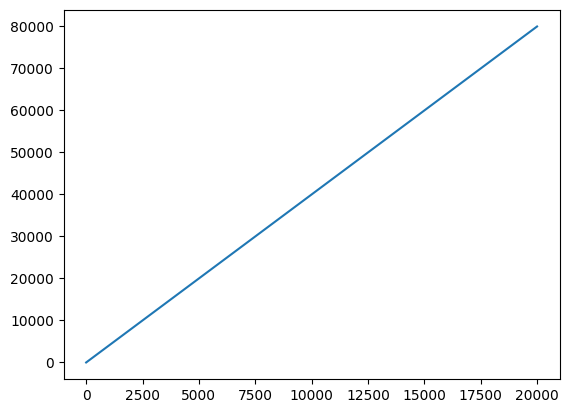

In [4]:
dt = 2
x = generate_signal(10000, dt, 0.1*0, 0.05*0, 2,random_state=1111000)

import matplotlib.pyplot as plt

plt.plot(x["t"],x["signal"])

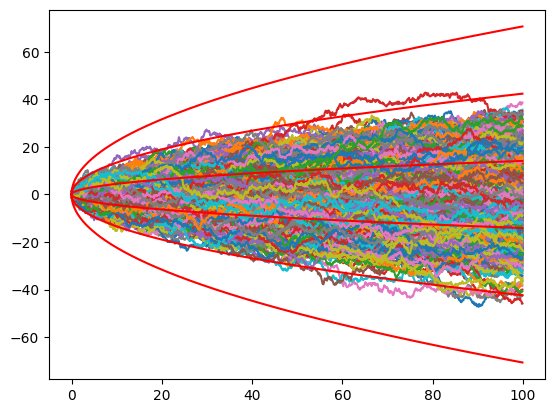

In [9]:
import numpy as np
import matplotlib.pyplot as plt


R= 2.
t0 = 0
dt =0.1
tf = 100

n=1000

t = np.arange(t0,tf,dt)

rng = np.random.RandomState()
#walk =  np.cumsum((R/dt)** 0.5*rng.randn(len(t)))



sig = np.sqrt(R*t)


for idx in range(n):
    white = (R /dt)**0.5*rng.randn(len(t))
    walk = np.cumsum(white*dt)
    plt.plot(t, walk)

plt.plot(t,sig,c="red")
plt.plot(t,-sig,c="red")
plt.plot(t,3*sig,c="red")
plt.plot(t,-3*sig,c="red")
plt.plot(t,5*sig,c="red")
plt.plot(t,-5*sig,c="red")




walk    151.226419
Name: 0, dtype: float64


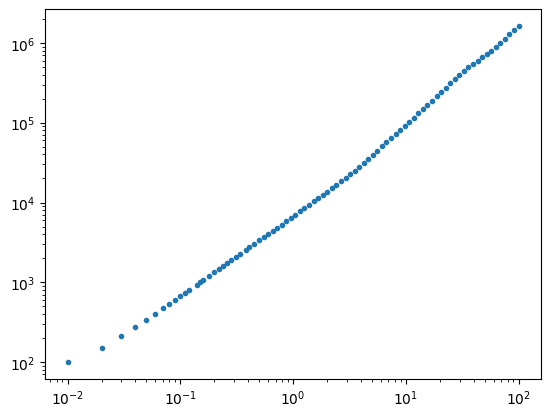

In [6]:
dt =0.01
tf = 1000
t = np.arange(t0,tf,dt)
white = (R /dt)**0.5*rng.randn(len(t))
walk = np.cumsum(white*dt)


tau, av = allan_variance(walk,dt=dt, input_type='increment')
plt.loglog(tau, av, '.')
params, av_pred = params_from_avar(tau, av,effects=["walk"])
print(params)

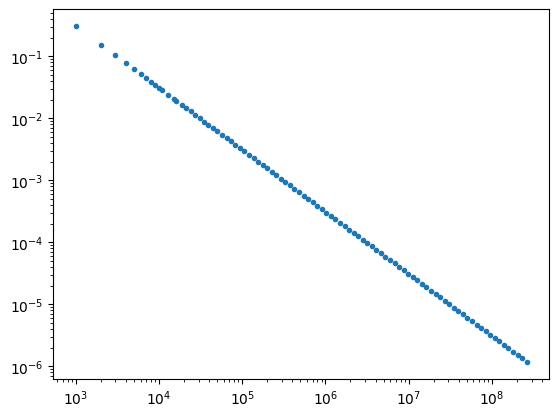

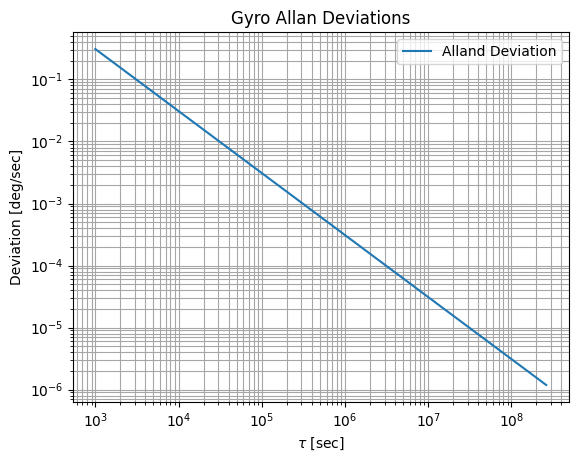

In [7]:
def AllanDeviation(dataArr: np.ndarray, fs: float, maxNumM: int=100):
    """Compute the Allan deviation (sigma) of time-series data.

    Algorithm obtained from Mathworks:
    https://www.mathworks.com/help/fusion/ug/inertial-sensor-noise-analysis-using-allan-variance.html

    Args
    ----
        dataArr: 1D data array
        fs: Data sample frequency in Hz
        maxNumM: Number of output points
    
    Returns
    -------
        (taus, allanDev): Tuple of results
        taus (numpy.ndarray): Array of tau values
        allanDev (numpy.ndarray): Array of computed Allan deviations
    """
    ts = 1.0 / fs
    N = len(dataArr)
    Mmax = 2**np.floor(np.log2(N / 2))
    M = np.logspace(np.log10(1), np.log10(Mmax), num=maxNumM)
    M = np.ceil(M)  # Round up to integer
    M = np.unique(M)  # Remove duplicates
    taus = M * ts  # Compute 'cluster durations' tau

    # Compute Allan variance
    allanVar = np.zeros(len(M))
    for i, mi in enumerate(M):
        twoMi = int(2 * mi)
        mi = int(mi)
        allanVar[i] = np.sum(
            (dataArr[twoMi:N] - (2.0 * dataArr[mi:N-mi]) + dataArr[0:N-twoMi])**2
        )
    
    allanVar /= (2.0 * taus**2) * (N - (2.0 * M))
    return (taus, np.sqrt(allanVar))  # Return deviation (dev = sqrt(var))

# params, av_pred = params_from_avar(tau, av)
# print(params)

# plt.loglog(tau, av, '.')
# plt.loglog(tau, av_pred)

dt =0.001
tf = 1000
t = np.arange(t0,tf,dt)
white = (R /dt)**0.5*rng.randn(len(t))
walk = np.cumsum(white*dt)


(tau, ad) = AllanDeviation(walk+4*white, dt, maxNumM=100)

plt.loglog(tau, ad, '.')


plt.figure()
plt.title('Gyro Allan Deviations')
plt.plot(tau, ad, label='Alland Deviation')
plt.xlabel(r'$\tau$ [sec]')
plt.ylabel('Deviation [deg/sec]')
plt.grid(True, which="both", ls="-", color='0.65')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()


In [8]:
import allantools
nn=1000000
dt=1

x = allantools.noise.white(num_points=nn,fs=2/0.1,b0=2)
x2 = generate_signal(
    n=nn,
    dt=0.1,
    q_ramp=0,
    q_walk=0,
    q_white=2)


print(np.std(x2["signal"]))
print(np.std(x))



ModuleNotFoundError: No module named 'allantools'

Done.


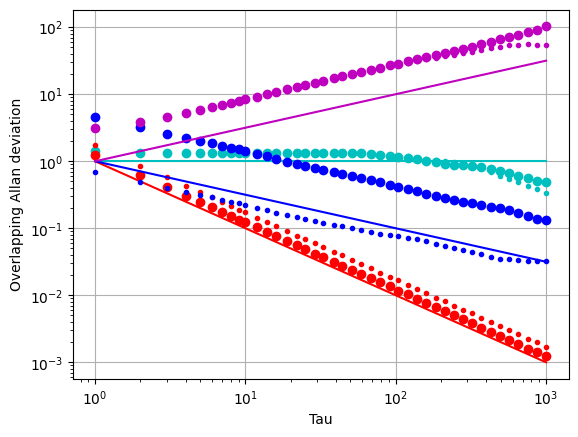

In [ ]:
import numpy
import matplotlib.pyplot as plt 
import allantools
from allantools import noise

def plotallan(plt, y, rate, taus, style):
    (t2, ad, ade, adn) = allantools.oadev(y, rate=rate, data_type="freq", taus=taus)
    plt.loglog(t2, ad, style)


def plotallan_phase(plt, y, rate, taus, style):
    (t2, ad, ade, adn) = allantools.oadev(y, rate=rate, taus=taus)
    plt.loglog(t2, ad, style)


def plotline(plt, alpha, taus, style):
    """ plot a line with the slope alpha """
    y = [pow(tt, alpha) for tt in taus]
    plt.loglog(taus, y, style)


t = numpy.logspace(0, 3, 50)  # tau values from 1 to 1000
plt.subplot(111, xscale="log", yscale="log")
N = 10000

# pink frequency noise => constant ADEV
freq_pink = noise.pink(N)
phase_p = numpy.cumsum(noise.pink(N))  # integrate to get phase, color??
plotallan_phase(plt, phase_p, 1, t, 'co')
plotallan(plt, freq_pink, 1, t, 'c.')
plotline(plt, 0, t, 'c')

# white phase noise => 1/tau ADEV
phase_white = noise.white(N)
plotallan_phase(plt, phase_white, 1, t, 'ro')
freq_w = noise.violet(N)  # diff to get frequency, "Violet noise"
plotallan(plt, freq_w, 1, t, 'r.')
plotline(plt, -1, t, 'r')

# white frequency modulation => 1/sqrt(tau) ADEV
freq_white = noise.white(N)
phase_rw = noise.brown(N)  # integrate to get Brownian, or random walk phase
plotallan(plt, freq_white, 1, t, 'b.')
plotallan_phase(plt, phase_rw, 1, t, 'bo')
plotline(plt, -0.5, t, 'b')


# Brownian a.k.a random walk  frequency => sqrt(tau) ADEV
freq_rw = noise.brown(N)
phase_rw_rw = numpy.cumsum(noise.brown(N))  # integrate to get  phase
plotallan(plt, freq_rw, 1, t, 'm.')
plotallan_phase(plt, phase_rw_rw, 1, t, 'mo')
plotline(plt, +0.5, t, 'm')

plt.xlabel('Tau')
plt.ylabel('Overlapping Allan deviation')
print("Done.")
plt.grid()
plt.show()



In [ ]:
import numpy as np
from scipy.linalg import expm


dt = 0.1
duration = 1000.

A = np.zeros([1,1])
F= expm(A*dt)

X0 = np.array([0.])

t= np.arange(0,duration,dt)

X= [0.]

for tc in t[1:]:

    Xc = 






SyntaxError: invalid syntax (3426707315.py, line 19)